<a href="https://colab.research.google.com/github/AnshulSingh-eZ/Machine_Learning_Lab_23CS067/blob/main/Exp_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converged after 23 iterations.


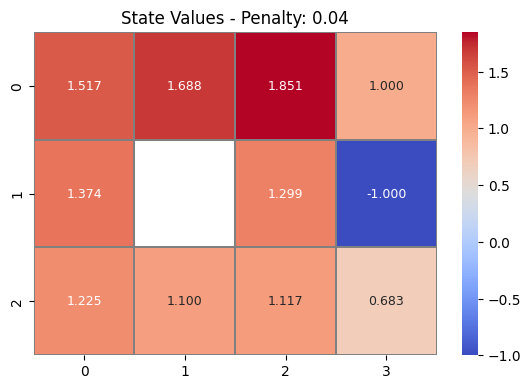


Optimal Policy:
 R   R   R  +1
 U   X   U  -1
 U   L   U   L


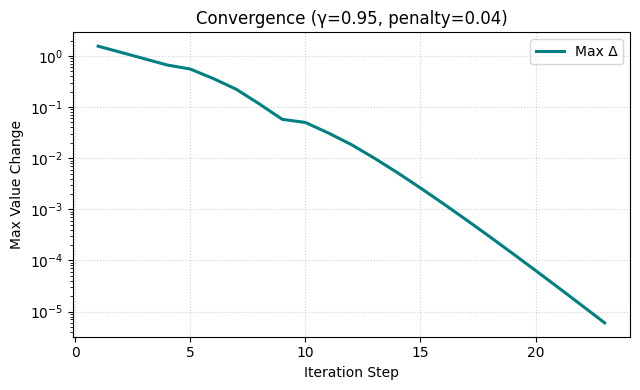

Converged after 25 iterations.


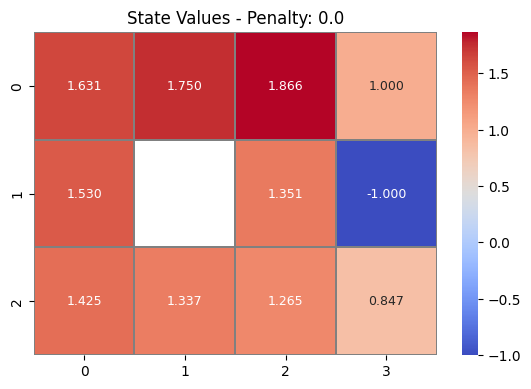


Optimal Policy:
 R   R   R  +1
 U   X   U  -1
 U   L   L   L


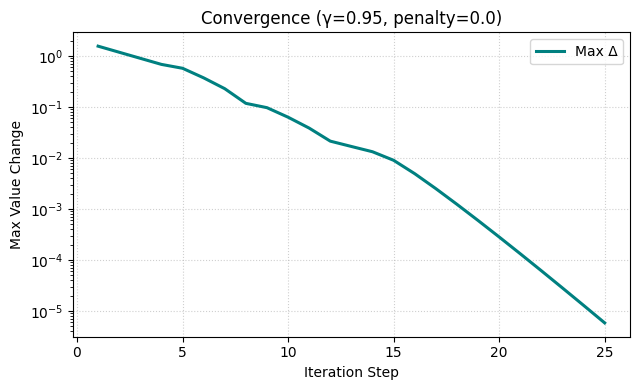

Converged after 23 iterations.


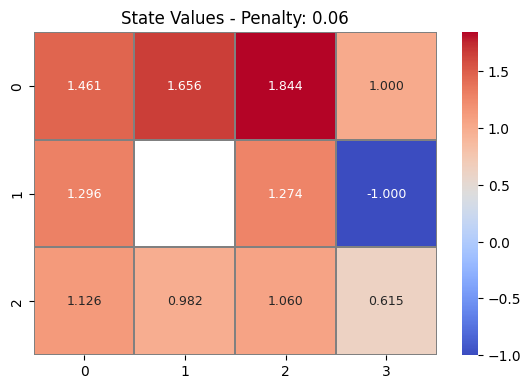


Optimal Policy:
 R   R   R  +1
 U   X   U  -1
 U   L   U   L


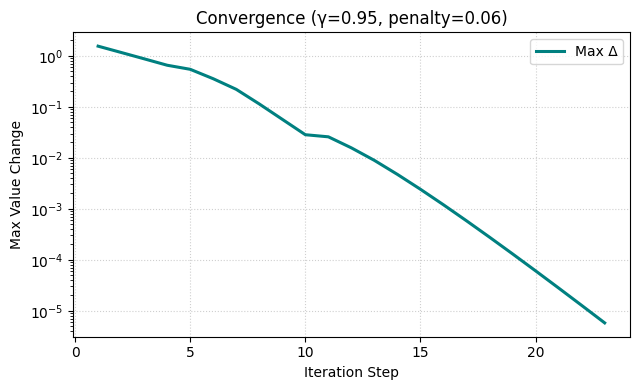

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Grid setup
rows, cols = 3, 4
states = [(i, j) for i in range(rows) for j in range(cols) if (i, j) != (1, 1)]
actions = ['up', 'down', 'left', 'right']
config = {"living_penalty": 0.04}

def R(s):
    if s == (0, 3):
        return 1.0
    elif s == (1, 3):
        return -1.0
    else:
        return -config['living_penalty']

def get_next_states(state, action):
    if state in [(0, 3), (1, 3)]:
        return [(1.0, state)] # Terminal states remain the same

    d = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}
    next_states = []
    x, y = state
    for a in d.keys():
        nx, ny = x + d[a][0], y + d[a][1]

        # Bounce back if hitting wall or forbidden state
        if nx >= rows or ny >= cols or nx < 0 or ny < 0 or (nx, ny) not in states:
            nx, ny = x, y
        # Set probability based on intended action
        if a == action:
            prob = 0.8
        elif (action == 'up' and a == 'down') or (action == 'down' and a == 'up') \
     or (action == 'left' and a == 'right') or (action == 'right' and a == 'left'):
            prob = 0
        else:
            prob = 0.1
        if prob > 0:
            next_states.append((prob, (nx, ny)))
    # Sanity check for probabilities
    total_prob = sum(p for p, _ in next_states)
    if abs(total_prob - 1.0) > 1e-12:
        print(f"Warning: probs sum to {total_prob} for state {state}, action {action}")
    return next_states

def value_iteration(gamma=0.95, theta=1e-5, max_iter=None):
    deltas = []
    V = {s: 0.0 for s in states}
    V[(0, 3)] = R((0, 3))
    V[(1, 3)] = R((1, 3))
    i = 0

    while True:
        delta = 0
        V_next = V.copy()

        for s in states:
            if s in [(0, 3), (1, 3)]:
                V_next[s] = R(s)
                continue

            action_values = []
            for a in actions:
                v = 0
                # Compute expected value for this action
                for prob, s_next in get_next_states(s, a):
                    reward = R(s_next)
                    v += prob * (reward + gamma * V[s_next])
                action_values.append(v)
            # Update value with best action
            V_next[s] = max(action_values)
            delta = max(delta, abs(V[s] - V_next[s]))

        V = V_next
        i += 1
        if max_iter is not None and i > max_iter:
            break

        deltas.append(delta)
        if delta < theta:
            print(f"Converged after {i} iterations.")
            break

    return V, deltas

def extract_policy(V, gamma=0.95):
    Pi = {}
    for s in states:
        if s in [(0, 3), (1, 3)]:
            continue

        action_values = {}
        for a in actions:
            q = 0
            # Compute Q-value for each action
            for prob, s_next in get_next_states(s, a):
                q += prob * (R(s_next) + gamma * V[s_next])
            action_values[a] = q

        Pi[s] = max(action_values, key=action_values.get) # Pick best action
    return Pi

def visualize_value_function(V, penalty_label):
    grid = np.zeros((3, 4))
    for i in range(3):
        for j in range(4):
            if (i, j) == (1, 1):
                grid[i, j] = np.nan # Wall
            elif (i, j) in V:
                grid[i, j] = V[(i, j)]
            else:
                grid[i, j] = 0
    plt.figure(figsize=(6.5, 4.2))
    ax = sns.heatmap(grid, annot=True, fmt=".3f", cmap="coolwarm", cbar=True,
                     linewidths=1.2, linecolor='gray', annot_kws={"size": 9})
    plt.title(f"State Values - Penalty: {penalty_label}")
    plt.savefig(f'values_gamma095_penalty_{penalty_label}.png', dpi=400, bbox_inches='tight')
    plt.show()

def visualize_policy(Pi):
    arrow_map = {"up": "U", "down": "D", "left": "L", "right": "R"}
    grid = np.empty((3, 4), dtype=object)

    for i in range(3):
        for j in range(4):
            if (i, j) == (1, 1):
                grid[i, j] = "X"
            elif (i, j) == (0, 3):
                grid[i, j] = "+1"
            elif (i, j) == (1, 3):
                grid[i, j] = "-1"
            elif (i, j) in Pi:
                grid[i, j] = arrow_map.get(Pi[(i, j)], ".")
            else:
                grid[i, j] = "."
    print("\nOptimal Policy:")
    for row in grid:
        print("  ".join(f"{cell:>2}" for cell in row))

def plot_deltas(deltas, penalty_label, log_scale=True):
    plt.figure(figsize=(6.5, 4))
    x = np.arange(1, len(deltas) + 1)
    plt.plot(x, deltas, color='teal', linewidth=2.2, label='Max Δ')

    if log_scale:
        plt.yscale('log')

    plt.xlabel("Iteration Step")
    plt.ylabel("Max Value Change")
    plt.title(f"Convergence (γ=0.95, penalty={penalty_label})")
    plt.grid(True, alpha=0.6, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'convergence_gamma095_p{penalty_label}.png', dpi=400, bbox_inches='tight')
    plt.show()

# === Run Experiments with Different Penalties ===

# Case 1: Default penalty
config["living_penalty"] = 0.04
V1, d1 = value_iteration(gamma=0.95, theta=1e-5)
P1 = extract_policy(V1, gamma=0.95)
visualize_value_function(V1, "0.04")
visualize_policy(P1)
plot_deltas(d1, "0.04")

# Case 2: Zero penalty
config["living_penalty"] = 0.0
V2, d2 = value_iteration(gamma=0.95, theta=1e-5)
P2 = extract_policy(V2, gamma=0.95)
visualize_value_function(V2, "0.0")
visualize_policy(P2)
plot_deltas(d2, "0.0")

# Case 3: Higher penalty
config["living_penalty"] = 0.06
V3, d3 = value_iteration(gamma=0.95, theta=1e-5)
P3 = extract_policy(V3, gamma=0.95)
visualize_value_function(V3, "0.06")
visualize_policy(P3)
plot_deltas(d3, "0.06")